# DSRF + Ground Tabular


 - Image-only ConvLSTM on DSRF
 - Fusion: DSRF + tabular sequences

 Uses ground_*_h6.parquet and GOES_v2/DSRF NPZ files.

In [14]:
import os, warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import tensorflow as tf
from tensorflow.keras import layers, models, callbacks

## Config

In [15]:
SEED = 42
np.random.seed(SEED); tf.random.set_seed(SEED)

gpus = tf.config.list_physical_devices("GPU")
for g in gpus:
    try:
        tf.config.experimental.set_memory_growth(g, True)
    except Exception:
        pass
print("TF GPUs:", gpus)

# Paths (adjust ROOT if needed)
ROOT      = Path("..").resolve()
DATA_DIR  = ROOT / "data_processed"
GOES_DIR  = Path("/mnt/SOLARLAB/E_Ladino/Repo/irradiance-fusion-forecast/data_processed/GOES_v2")
DSRF_DIR  = GOES_DIR / "DSRF"

OUT_DIR   = ROOT / "outputs_dsrf_ground"
OUT_DIR.mkdir(parents=True, exist_ok=True)
FIG_DIR   = OUT_DIR / "figures"
FIG_DIR.mkdir(parents=True, exist_ok=True)

# Ground dataset (H=6 → 60 min)
TRAIN_PQ = DATA_DIR / "ground_train_h6.parquet"
VAL_PQ   = DATA_DIR / "ground_val_h6.parquet"
TEST_PQ  = DATA_DIR / "ground_test_h6.parquet"
TARGET   = "y_ghi_h6"

# Sequence length (number of 10-min steps in the history window)
SEQ_LEN  = 12   # 2h history
PATIENCE = 10

IMG_SIZE = 32   # from original DSRF scripts

print("DATA_DIR:", DATA_DIR.resolve())
print("GOES_DIR:", GOES_DIR.resolve())


TF GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
DATA_DIR: /mnt/SOLARLAB/E_Ladino/Repo/irradiance-fusion-forecast/data_processed
GOES_DIR: /mnt/SOLARLAB/E_Ladino/Repo/irradiance-fusion-forecast/data_processed/GOES_v2


## Helpers

In [16]:
def _rmse(a, b):
    return float(np.sqrt(mean_squared_error(a, b)))

def skill(y_true, y_pred, y_base):
    return 1.0 - (_rmse(y_true, y_pred) / (_rmse(y_true, y_base) + 1e-6))

def build_baseline(test_df, ytr, target_col):
    """Persistence-like baseline, aligned with your previous ground scripts."""
    if target_col.startswith("y_ghi"):
        candidates = ["ghi_qc", "ghi_sg_definitive", "ghi_qc_lag1"]
    else:
        candidates = ["k_ghi", "k_raw", "k_ghi_lag1", "k_raw_lag1"]

    base_src = None
    for c in candidates:
        if c in test_df.columns:
            base_src = test_df[c]
            break
    if base_src is None:
        base_src = pd.Series(np.nanmedian(ytr), index=test_df.index)
        print("WARNING: baseline degenerada (mediana).")
    return base_src.to_numpy()

def hourly_skill_df(y_true, y_pred, y_base, idx):
    """
    Skill vs persistencia por hora del día:
    skill(h) = 1 - RMSE_model(h) / RMSE_base(h).
    """
    df = pd.DataFrame({
        "time": idx,
        "y_true": y_true,
        "y_pred": y_pred,
        "y_base": y_base,
    }).set_index("time")
    df["hour"] = df.index.hour

    rows = []
    for h in range(24):
        sub = df[df["hour"] == h]
        if len(sub) < 10:
            continue
        rmse_m = _rmse(sub["y_true"], sub["y_pred"])
        rmse_b = _rmse(sub["y_true"], sub["y_base"])
        skl = 1.0 - rmse_m / (rmse_b + 1e-6)
        rows.append((h, rmse_m, rmse_b, skl))

    if not rows:
        return pd.DataFrame(columns=["rmse_model", "rmse_base", "skill"])

    res = pd.DataFrame(rows, columns=["hour", "rmse_model", "rmse_base", "skill"]).set_index("hour")
    return res

# --- Sequence builders (tabular + images) ---

def build_tab_seq_with_idx(X_2d, y_1d, idx, L):
    """
    Sliding window on tabular features only.
    X_2d: (N, F), y_1d: (N,), idx: DatetimeIndex
    Returns:
      X_seq: (N', L, F)
      y_seq: (N',)
      idx_seq: DatetimeIndex (label timestamps)
    """
    N, F = X_2d.shape
    xs, ys, idx_list = [], [], []
    for i in range(L-1, N):
        block = X_2d[i-L+1:i+1]
        if np.isnan(block).any():
            continue
        xs.append(block)
        ys.append(y_1d[i])
        idx_list.append(idx[i])
    if not xs:
        return (
            np.zeros((0, L, F), dtype="float32"),
            np.zeros((0,), dtype="float32"),
            pd.DatetimeIndex([])
        )
    return (
        np.asarray(xs, dtype="float32"),
        np.asarray(ys, dtype="float32"),
        pd.DatetimeIndex(idx_list)
    )

def build_img_seq_with_idx(imgs_4d, y_1d, idx, L):
    """
    Sliding window on image tensor only.
    imgs_4d: (N, H, W, C)
    Returns:
      X_seq_img: (N', L, H, W, C)
      y_seq: (N',)
      idx_seq: DatetimeIndex
    """
    N = imgs_4d.shape[0]
    H, W, C = imgs_4d.shape[1:]
    xs, ys, idx_list = [], [], []
    for i in range(L-1, N):
        block = imgs_4d[i-L+1:i+1]
        if np.isnan(block).any():
            continue
        xs.append(block)
        ys.append(y_1d[i])
        idx_list.append(idx[i])
    if not xs:
        return (
            np.zeros((0, L, H, W, C), dtype="float32"),
            np.zeros((0,), dtype="float32"),
            pd.DatetimeIndex([])
        )
    return (
        np.asarray(xs, dtype="float32"),
        np.asarray(ys, dtype="float32"),
        pd.DatetimeIndex(idx_list)
    )

def build_fusion_seq_with_idx(X_2d, imgs_4d, y_1d, idx, L):
    """
    Joint sequences: tabular + DSRF images.
    Returns:
      X_tab_seq: (N', L, F)
      X_img_seq: (N', L, H, W, C)
      y_seq    : (N',)
      idx_seq  : DatetimeIndex
    """
    N, F = X_2d.shape
    H, W, C = imgs_4d.shape[1:]
    xs_tab, xs_img, ys, idx_list = [], [], [], []
    for i in range(L-1, N):
        block_tab = X_2d[i-L+1:i+1]
        block_img = imgs_4d[i-L+1:i+1]
        if np.isnan(block_tab).any() or np.isnan(block_img).any():
            continue
        xs_tab.append(block_tab)
        xs_img.append(block_img)
        ys.append(y_1d[i])
        idx_list.append(idx[i])
    if not xs_tab:
        return (
            np.zeros((0, L, F), dtype="float32"),
            np.zeros((0, L, H, W, C), dtype="float32"),
            np.zeros((0,), dtype="float32"),
            pd.DatetimeIndex([])
        )
    return (
        np.asarray(xs_tab, dtype="float32"),
        np.asarray(xs_img, dtype="float32"),
        np.asarray(ys, dtype="float32"),
        pd.DatetimeIndex(idx_list)
    )

### Plot helpers

In [17]:
def plot_ts_clip(idx, y_true, y_pred, y_base, name, out_dir: Path, N=400):
    N = min(N, len(y_true))
    plt.figure(figsize=(12, 3.6))
    plt.plot(idx[:N], y_true[:N], label="truth", lw=1.4)
    plt.plot(idx[:N], y_pred[:N], label=name, lw=1.1)
    if y_base is not None:
        plt.plot(idx[:N], y_base[:N], label="baseline", lw=1.0, alpha=0.7)
    plt.title(f"Test — Truth vs {name} vs Baseline")
    plt.ylabel("GHI (W/m²)")
    plt.xlabel("Time")
    plt.grid(True, ls="--", alpha=0.3)
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    fname = out_dir / f"{name}_ts_test.png"
    plt.savefig(fname, dpi=140)
    plt.show()
    return fname

def plot_scatter(y_true, y_pred, name, out_dir: Path):
    rmse = _rmse(y_true, y_pred)
    mae  = mean_absolute_error(y_true, y_pred)
    r2   = r2_score(y_true, y_pred)
    lim_min = float(min(np.min(y_true), np.min(y_pred)))
    lim_max = float(max(np.max(y_true), np.max(y_pred)))
    plt.figure(figsize=(4.8, 4.8))
    plt.scatter(y_true, y_pred, s=10, alpha=0.5)
    plt.plot([lim_min, lim_max], [lim_min, lim_max], 'r--', lw=1.0)
    plt.xlabel("Actual GHI (W/m²)")
    plt.ylabel("Predicted GHI (W/m²)")
    plt.title(f"{name} — Actual vs Predicted\nRMSE={rmse:.3f} MAE={mae:.3f} R2={r2:.3f}")
    plt.grid(True, ls="--", alpha=0.3)
    plt.tight_layout()
    fname = out_dir / f"{name}_scatter.png"
    plt.savefig(fname, dpi=140)
    plt.show()
    return fname

def plot_residuals(y_true, y_pred, name, out_dir: Path):
    resid = y_pred - y_true
    plt.figure(figsize=(6, 3.2))
    plt.hist(resid, bins=50, alpha=0.85)
    plt.axvline(0, color='r', ls='--', lw=1)
    plt.title(f"{name} — Residuals (mean={np.mean(resid):.3f})")
    plt.xlabel("Residual (W/m²)")
    plt.ylabel("Frequency")
    plt.grid(True, ls="--", alpha=0.3)
    plt.tight_layout()
    fname = out_dir / f"{name}_residuals.png"
    plt.savefig(fname, dpi=140)
    plt.show()
    return fname

def plot_hourly_skill(sk_df, name, out_dir: Path):
    if sk_df.empty:
        return None
    plt.figure(figsize=(7, 3.5))
    plt.plot(sk_df.index, sk_df["skill"], marker="o")
    plt.axhline(0.0, ls="--", lw=1, color="k")
    plt.xlabel("Hour of day")
    plt.ylabel("Skill vs persistence")
    plt.title(f"{name} — Hourly skill vs persistence (test)")
    plt.grid(True, ls="--", alpha=0.3)
    plt.xticks(range(0, 24))
    plt.tight_layout()
    fname = out_dir / f"{name}_hourly_skill.png"
    plt.savefig(fname, dpi=150)
    plt.show()
    return fname

## Loading

In [18]:
def load_dsrf_for_index(time_index: pd.DatetimeIndex,
                        dsrf_dir: Path = DSRF_DIR,
                        target_size: int = IMG_SIZE):
    """
    Build DSRF tensor aligned with the given time_index.
    Assumes NPZ layout: dsrf_dir/YYYY/MM/YYYYMMDD_HH_DSRF.npz
    with shape (1, 256, 256) inside, downsampled to target_size x target_size.

    Returns:
      dsrf_all: (N, H, W, 1)
    """
    hours = time_index.floor("H")
    unique_hours = sorted(hours.unique())

    hour_to_img = {}
    missing_hours = 0

    assert 256 % target_size == 0, "Expecting 256x256 DSRF arrays."
    step = 256 // target_size

    for h in unique_hours:
        key = h.strftime("%Y%m%d_%H")
        year = key[:4]
        month = key[4:6]
        fname = f"{key}_DSRF.npz"
        path = dsrf_dir / year / month / fname
        if not path.exists():
            # neutral frame if missing
            img = np.zeros((target_size, target_size), dtype="float32")
            hour_to_img[key] = img
            missing_hours += 1
            continue

        data = np.load(path)
        arr = data[list(data.files)[0]].astype("float32")  # (1,256,256)
        img = arr[0][::step, ::step]                       # to target_size
        img = np.nan_to_num(img, nan=0.0, posinf=0.0, neginf=0.0)
        hour_to_img[key] = img

    print(f"DSRF: unique hours in index = {len(unique_hours)}")
    print(f"DSRF: missing files        = {missing_hours}")

    imgs = []
    for ts in time_index:
        key = ts.strftime("%Y%m%d_%H")
        img = hour_to_img.get(key, np.zeros((target_size, target_size), dtype="float32"))
        imgs.append(img[..., None])  # add channel dim
    dsrf_all = np.stack(imgs, axis=0).astype("float32")

    # Global normalization for this split
    dsrf_all = np.nan_to_num(dsrf_all, nan=0.0, posinf=0.0, neginf=0.0)
    mean = dsrf_all.mean()
    std  = dsrf_all.std() + 1e-6
    print(f"DSRF mean={mean:.3f}, std={std:.3f}")
    dsrf_all = (dsrf_all - mean) / std

    assert np.isfinite(dsrf_all).all(), "NaN/Inf in dsrf_all"
    return dsrf_all


In [19]:
# Data loading (ground tabular + DSRF)
train = pd.read_parquet(TRAIN_PQ).sort_index()
val   = pd.read_parquet(VAL_PQ).sort_index()
test  = pd.read_parquet(TEST_PQ).sort_index()
assert TARGET in train.columns, f"{TARGET} missing!"

# Features: common numeric, excluding any y_*
common_cols = set(train.columns) & set(val.columns) & set(test.columns)
feat_cols = sorted([
    c for c in common_cols
    if (c != TARGET) and (not c.startswith("y_")) and
       pd.api.types.is_numeric_dtype(train[c])
])
print("Num features:", len(feat_cols))

Xtr_df, ytr = train[feat_cols], train[TARGET].to_numpy()
Xva_df, yva = val[feat_cols],   val[TARGET].to_numpy()
Xte_df, yte = test[feat_cols],  test[TARGET].to_numpy()

scaler = StandardScaler()
Xtr = scaler.fit_transform(Xtr_df)
Xva = scaler.transform(Xva_df)
Xte = scaler.transform(Xte_df)

# Baseline on test
y_base_full = build_baseline(test, ytr, TARGET)
print(f"Baseline test → RMSE: {_rmse(yte, y_base_full):.4f} | MAE: {mean_absolute_error(yte, y_base_full):.4f}")

# DSRF tensors per split (aligned with each index)
print("\nLoading DSRF tensors…")
dsrf_tr = load_dsrf_for_index(train.index)
dsrf_va = load_dsrf_for_index(val.index)
dsrf_te = load_dsrf_for_index(test.index)
print("dsrf_tr:", dsrf_tr.shape, "dsrf_va:", dsrf_va.shape, "dsrf_te:", dsrf_te.shape)

Num features: 45
Baseline test → RMSE: 196.2835 | MAE: 102.1871

Loading DSRF tensors…
DSRF: unique hours in index = 9634
DSRF: missing files        = 149
DSRF mean=181.967, std=277.663
DSRF: unique hours in index = 2065
DSRF: missing files        = 35
DSRF mean=202.128, std=293.142
DSRF: unique hours in index = 2064
DSRF: missing files        = 13
DSRF mean=201.762, std=290.642
dsrf_tr: (57791, 32, 32, 1) dsrf_va: (12385, 32, 32, 1) dsrf_te: (12384, 32, 32, 1)


## Models

In [20]:
def build_convlstm_dsrf(L, H=IMG_SIZE, W=IMG_SIZE, C=1,
                        filters1=16, filters2=32, k=3,
                        dense_units=64, dropout_rate=0.2):
    """
    Compact ConvLSTM encoder model for DSRF sequences.
    Input:  (L, H, W, C)
    Output: scalar GHI prediction.
    """
    inp = layers.Input(shape=(L, H, W, C))

    x = layers.ConvLSTM2D(
        filters=filters1,
        kernel_size=(k, k),
        padding="same",
        return_sequences=True,
        activation="tanh",
        dropout=dropout_rate,
        recurrent_dropout=dropout_rate
    )(inp)
    x = layers.BatchNormalization()(x)

    x = layers.ConvLSTM2D(
        filters=filters2,
        kernel_size=(k, k),
        padding="same",
        return_sequences=False,
        activation="tanh",
        dropout=dropout_rate,
        recurrent_dropout=dropout_rate
    )(x)
    x = layers.BatchNormalization()(x)

    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(dense_units, activation="relu")(x)
    x = layers.Dropout(dropout_rate)(x)

    out = layers.Dense(1, dtype="float32")(x)
    model = models.Model(inp, out, name="ConvLSTM_DSRF_ground")
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=5e-4),
                  loss="mse")
    return model

def build_dsrf_tabular_fusion(L, n_feat, H=IMG_SIZE, W=IMG_SIZE, C=1,
                              img_emb_dim=64, tab_units=64,
                              dense_units=64, dropout_rate=0.2):
    """
    Fusion:
      - image branch: TimeDistributed CNN encoder + LSTM
      - tabular branch: LSTM
      - concatenation → dense head → scalar output.
    """
    # Image branch
    inp_img = layers.Input(shape=(L, H, W, C), name="img_seq")

    cnn = models.Sequential(name="cnn_dsrf_frame")
    cnn.add(layers.Conv2D(16, (3,3), padding="same", activation="relu", input_shape=(H,W,C)))
    cnn.add(layers.BatchNormalization())
    cnn.add(layers.MaxPooling2D((2,2)))
    cnn.add(layers.Conv2D(32, (3,3), padding="same", activation="relu"))
    cnn.add(layers.BatchNormalization())
    cnn.add(layers.MaxPooling2D((2,2)))
    cnn.add(layers.Conv2D(64, (3,3), padding="same", activation="relu"))
    cnn.add(layers.BatchNormalization())
    cnn.add(layers.GlobalAveragePooling2D())
    cnn.add(layers.Dense(img_emb_dim, activation="relu"))

    x_img = layers.TimeDistributed(cnn, name="td_cnn")(inp_img)
    x_img = layers.LSTM(64, activation="tanh", name="lstm_img")(x_img)

    # Tabular branch
    inp_tab = layers.Input(shape=(L, n_feat), name="tab_seq")
    x_tab = layers.LSTM(tab_units, activation="tanh", name="lstm_tab")(inp_tab)

    # Fusion
    x = layers.Concatenate(name="fusion")([x_img, x_tab])
    x = layers.Dense(dense_units, activation="relu")(x)
    x = layers.Dropout(dropout_rate)(x)
    out = layers.Dense(1, dtype="float32", name="y_hat")(x)

    model = models.Model([inp_img, inp_tab], out, name="DSRF_Tabular_Fusion_ground")
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=5e-4),
                  loss="mse")
    return model

## Sequences

In [21]:
# Train sequences
Xtr_tab_seq, ytr_seq, idx_tr_seq = build_tab_seq_with_idx(Xtr, ytr, train.index, SEQ_LEN)
Xtr_img_seq, ytr_img, idx_tr_img = build_img_seq_with_idx(dsrf_tr, ytr, train.index, SEQ_LEN)
Xtr_tabf, Xtr_imgf, ytr_f, idx_tr_f = build_fusion_seq_with_idx(Xtr, dsrf_tr, ytr, train.index, SEQ_LEN)

# Val sequences
Xva_tab_seq, yva_seq, idx_va_seq = build_tab_seq_with_idx(Xva, yva, val.index, SEQ_LEN)
Xva_img_seq, yva_img, idx_va_img = build_img_seq_with_idx(dsrf_va, yva, val.index, SEQ_LEN)
Xva_tabf, Xva_imgf, yva_f, idx_va_f = build_fusion_seq_with_idx(Xva, dsrf_va, yva, val.index, SEQ_LEN)

# Test sequences
Xte_tab_seq, yte_seq, idx_te_seq = build_tab_seq_with_idx(Xte, yte, test.index, SEQ_LEN)
Xte_img_seq, yte_img, idx_te_img = build_img_seq_with_idx(dsrf_te, yte, test.index, SEQ_LEN)
Xte_tabf, Xte_imgf, yte_f, idx_te_f = build_fusion_seq_with_idx(Xte, dsrf_te, yte, test.index, SEQ_LEN)

print("Train DSRF image-only seq:", Xtr_img_seq.shape, ytr_img.shape)
print("Train fusion seq (tab + img):", Xtr_tabf.shape, Xtr_imgf.shape, ytr_f.shape)
print("Test DSRF image-only seq:", Xte_img_seq.shape, yte_img.shape)
print("Test fusion seq:", Xte_tabf.shape, Xte_imgf.shape, yte_f.shape)

# Align baseline for sequences (test)
y_base_seq_img = pd.Series(y_base_full, index=test.index).reindex(idx_te_img).to_numpy()
y_base_seq_fus = pd.Series(y_base_full, index=test.index).reindex(idx_te_f).to_numpy()


Train DSRF image-only seq: (57780, 12, 32, 32, 1) (57780,)
Train fusion seq (tab + img): (57780, 12, 45) (57780, 12, 32, 32, 1) (57780,)
Test DSRF image-only seq: (12373, 12, 32, 32, 1) (12373,)
Test fusion seq: (12373, 12, 45) (12373, 12, 32, 32, 1) (12373,)


## Training

### DSRF

In [22]:
es = callbacks.EarlyStopping(
    monitor="val_loss",
    patience=PATIENCE,
    restore_best_weights=True,
    verbose=1
)

model_dsrf = build_convlstm_dsrf(L=SEQ_LEN, H=IMG_SIZE, W=IMG_SIZE, C=1)
print(model_dsrf.summary())

hist = model_dsrf.fit(
    Xtr_img_seq, ytr_img,
    validation_data=(Xva_img_seq, yva_img),
    epochs=60,
    batch_size=8,
    verbose=1,
    callbacks=[es]
)

yhat_img = model_dsrf.predict(Xte_img_seq, verbose=0).squeeze()

rmse_img = _rmse(yte_img, yhat_img)
mae_img  = mean_absolute_error(yte_img, yhat_img)
r2_img   = r2_score(yte_img, yhat_img)
skill_img = skill(yte_img, yhat_img, y_base_seq_img)

print("\n=== DSRF image-only (ConvLSTM) — Test metrics ===")
print(f"RMSE={rmse_img:.4f} | MAE={mae_img:.4f} | R2={r2_img:.4f} | Skill={skill_img:.3f}")

Model: "ConvLSTM_DSRF_ground"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 12, 32, 32, 1)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_lstm2d_2 (ConvLSTM2D)      │ (None, 12, 32, 32, 16) │         9,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 12, 32, 32, 16) │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_lstm2d_3 (ConvLSTM2D)      │ (None, 32, 32, 32)     │        55,424 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 32)             │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 67,649 (264.25 KB)

 Trainable params: 67,553 (263.88 KB)

 Non-trainable params: 96 (384.00 B)

None
Epoch 1/60
7223/7223 ━━━━━━━━━━━━━━━━━━━━ 99s 13ms/step - loss: 36918.0625 - val_loss: 29062.8164
Epoch 2/60
7223/7223 ━━━━━━━━━━━━━━━━━━━━ 88s 12ms/step - loss: 29231.7461 - val_loss: 28530.0879
Epoch 3/60
7223/7223 ━━━━━━━━━━━━━━━━━━━━ 88s 12ms/step - loss: 28427.4297 - val_loss: 29550.8730
Epoch 4/60
7223/7223 ━━━━━━━━━━━━━━━━━━━━ 88s 12ms/step - loss: 27948.6953 - val_loss: 28945.7695
Epoch 5/60
7223/7223 ━━━━━━━━━━━━━━━━━━━━ 89s 12ms/step - loss: 27609.3594 - val_loss: 30252.5703
Epoch 6/60
7223/7223 ━━━━━━━━━━━━━━━━━━━━ 89s 12ms/step - loss: 27411.2852 - val_loss: 30057.6621
Epoch 7/60
7223/7223 ━━━━━━━━━━━━━━━━━━━━ 89s 12ms/step - loss: 27032.9062 - val_loss: 28472.6523
Epoch 8/60
7223/7223 ━━━━━━━━━━━━━━━━━━━━ 89s 12ms/step - loss: 26891.2695 - val_loss: 33889.3516
Epoch 9/60
7223/7223 ━━━━━━━━━━━━━━━━━━━━ 89s 12ms/step - loss: 26843.5508 - val_loss: 30656.5527
Epoch 10/60
7223/7223 ━━━━━━━━━━━━━━━━━━━━ 89s 12ms/step - loss: 26561.1230 - val_loss: 29001.2031
Epoch 11/60
72

#### Plots

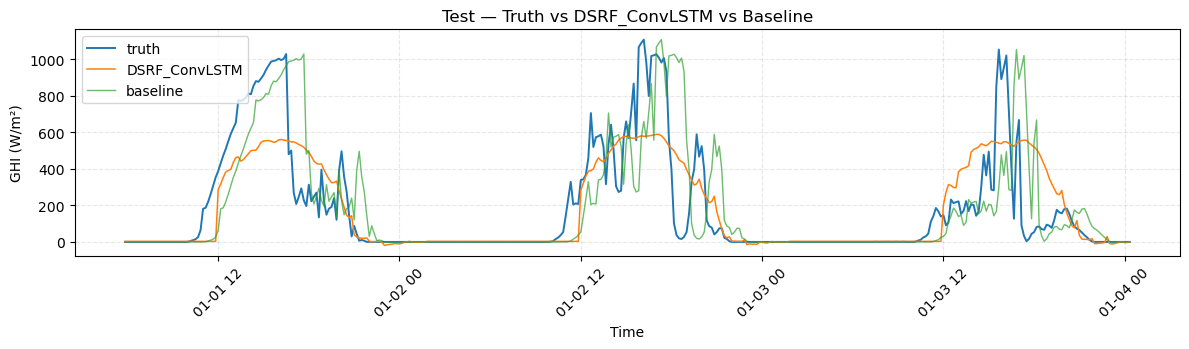

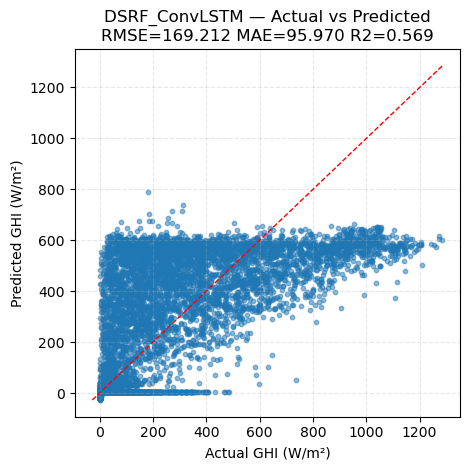

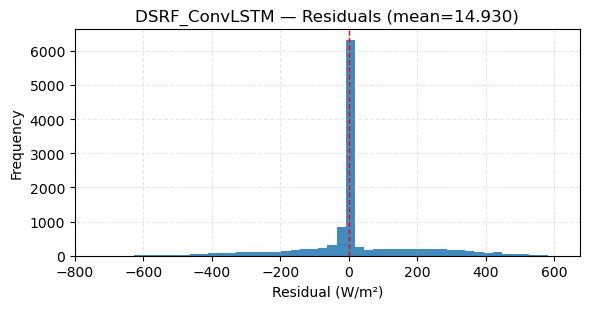

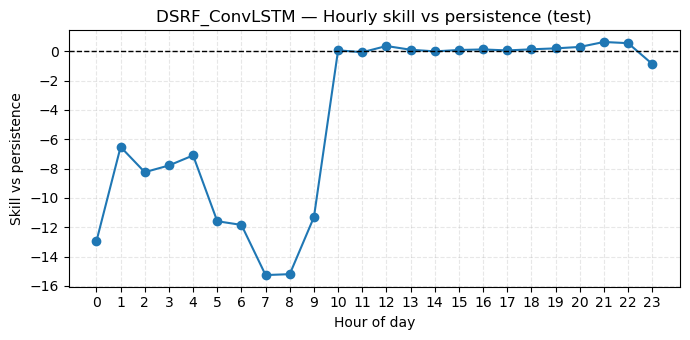

PosixPath('/mnt/SOLARLAB/E_Ladino/Repo/irradiance-fusion-forecast/outputs_dsrf_ground/figures/DSRF_ConvLSTM_hourly_skill.png')

In [23]:
plot_ts_clip(idx_te_img, yte_img, yhat_img, y_base_seq_img, "DSRF_ConvLSTM", FIG_DIR)
plot_scatter(yte_img, yhat_img, "DSRF_ConvLSTM", FIG_DIR)
plot_residuals(yte_img, yhat_img, "DSRF_ConvLSTM", FIG_DIR)

sk_df_img = hourly_skill_df(yte_img, yhat_img, y_base_seq_img, idx_te_img)
plot_hourly_skill(sk_df_img, "DSRF_ConvLSTM", FIG_DIR)

### DSRF + Tabular

In [24]:
model_fus = build_dsrf_tabular_fusion(L=SEQ_LEN, n_feat=Xtr.shape[1],
                                      H=IMG_SIZE, W=IMG_SIZE, C=1)
print(model_fus.summary())

es_fus = callbacks.EarlyStopping(
    monitor="val_loss",
    patience=PATIENCE + 2,
    restore_best_weights=True,
    verbose=1
)

hist_fus = model_fus.fit(
    {"img_seq": Xtr_imgf, "tab_seq": Xtr_tabf},
    ytr_f,
    validation_data=(
        {"img_seq": Xva_imgf, "tab_seq": Xva_tabf},
        yva_f
    ),
    epochs=60,
    batch_size=8,
    verbose=1,
    callbacks=[es_fus],
    shuffle=True,
)

yhat_fus = model_fus.predict(
    {"img_seq": Xte_imgf, "tab_seq": Xte_tabf},
    verbose=0
).squeeze()

rmse_fus = _rmse(yte_f, yhat_fus)
mae_fus  = mean_absolute_error(yte_f, yhat_fus)
r2_fus   = r2_score(yte_f, yhat_fus)
skill_fus = skill(yte_f, yhat_fus, y_base_seq_fus)

print("\n=== DSRF + Tabular Fusion — Test metrics ===")
print(f"RMSE={rmse_fus:.4f} | MAE={mae_fus:.4f} | R2={r2_fus:.4f} | Skill={skill_fus:.3f}")


Model: "DSRF_Tabular_Fusion_ground"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ img_seq             │ (None, 12, 32,    │          0 │ -                 │
│ (InputLayer)        │ 32, 1)            │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ td_cnn              │ (None, 12, 64)    │     27,904 │ img_seq[0][0]     │
│ (TimeDistributed)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ tab_seq             │ (None, 12, 45)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_img (LSTM)     │ (None, 64)        │     33,024 │ td_cnn[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_tab (LSTM)     │ (None, 64)        │     28,160 │ tab_seq[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ fusion              │ (None, 128)       │          0 │ lstm_img[0][0],   │
│ (Concatenate)       │                   │            │ lstm_tab[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_7 (Dense)     │ (None, 64)        │      8,256 │ fusion[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 64)        │          0 │ dense_7[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ y_hat (Dense)       │ (None, 1)         │         65 │ dropout_3[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 97,409 (380.50 KB)

 Trainable params: 97,185 (379.63 KB)

 Non-trainable params: 224 (896.00 B)

None
Epoch 1/60
7223/7223 ━━━━━━━━━━━━━━━━━━━━ 104s 14ms/step - loss: 21993.0508 - val_loss: 18296.4258
Epoch 2/60
7223/7223 ━━━━━━━━━━━━━━━━━━━━ 100s 14ms/step - loss: 16999.2910 - val_loss: 17827.5781
Epoch 3/60
7223/7223 ━━━━━━━━━━━━━━━━━━━━ 102s 14ms/step - loss: 16314.2822 - val_loss: 17591.0371
Epoch 4/60
7223/7223 ━━━━━━━━━━━━━━━━━━━━ 100s 14ms/step - loss: 15817.2441 - val_loss: 17542.2871
Epoch 5/60
7223/7223 ━━━━━━━━━━━━━━━━━━━━ 99s 14ms/step - loss: 15162.7734 - val_loss: 18192.6055
Epoch 6/60
7223/7223 ━━━━━━━━━━━━━━━━━━━━ 103s 14ms/step - loss: 14554.3398 - val_loss: 18388.1641
Epoch 7/60
7223/7223 ━━━━━━━━━━━━━━━━━━━━ 101s 14ms/step - loss: 13902.9922 - val_loss: 18803.6699
Epoch 8/60
7223/7223 ━━━━━━━━━━━━━━━━━━━━ 99s 14ms/step - loss: 13199.8516 - val_loss: 19211.7520
Epoch 9/60
7223/7223 ━━━━━━━━━━━━━━━━━━━━ 99s 14ms/step - loss: 12524.0576 - val_loss: 19416.2793
Epoch 10/60
7223/7223 ━━━━━━━━━━━━━━━━━━━━ 101s 14ms/step - loss: 11936.7500 - val_loss: 19879.1719
Epoch 1

#### Plots

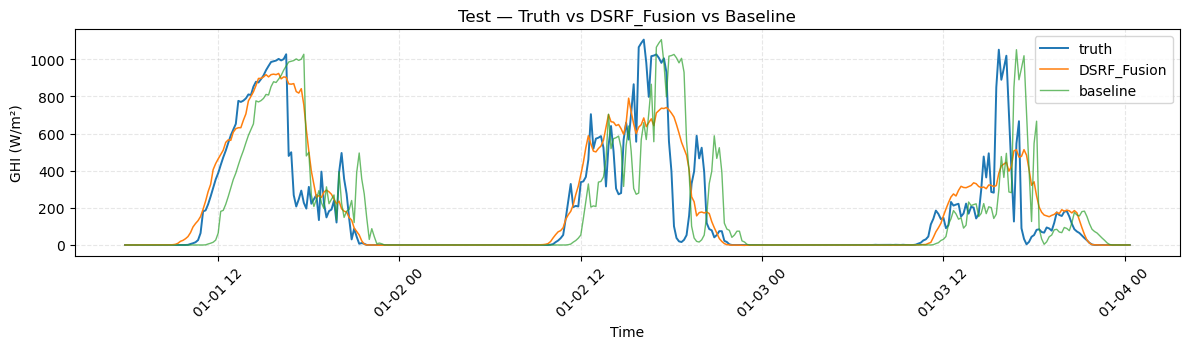

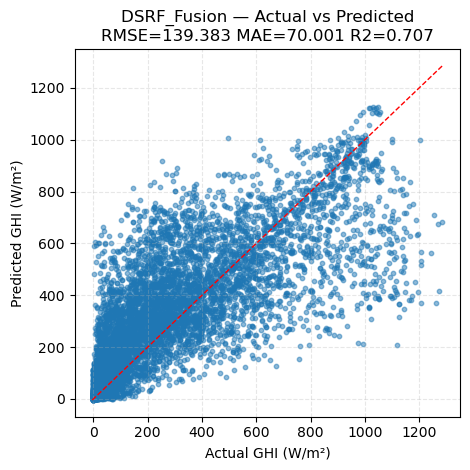

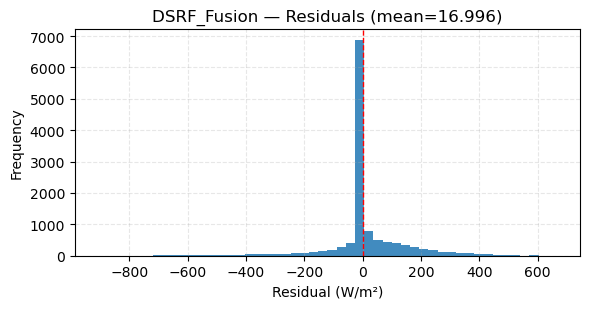

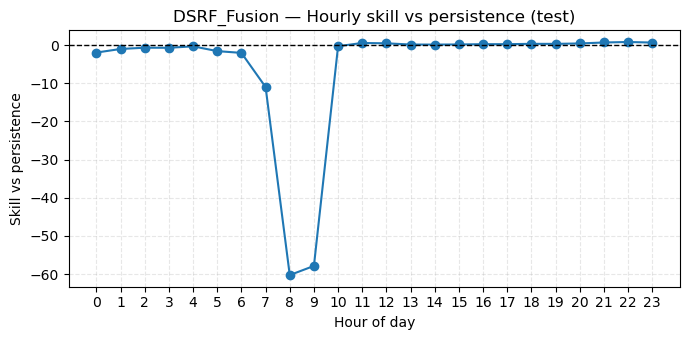

PosixPath('/mnt/SOLARLAB/E_Ladino/Repo/irradiance-fusion-forecast/outputs_dsrf_ground/figures/DSRF_Fusion_hourly_skill.png')

In [25]:
plot_ts_clip(idx_te_f, yte_f, yhat_fus, y_base_seq_fus, "DSRF_Fusion", FIG_DIR)
plot_scatter(yte_f, yhat_fus, "DSRF_Fusion", FIG_DIR)
plot_residuals(yte_f, yhat_fus, "DSRF_Fusion", FIG_DIR)

sk_df_fus = hourly_skill_df(yte_f, yhat_fus, y_base_seq_fus, idx_te_f)
plot_hourly_skill(sk_df_fus, "DSRF_Fusion", FIG_DIR)

## Summary

In [26]:
summary = pd.DataFrame({
    "DSRF_ConvLSTM": {
        "RMSE": rmse_img,
        "MAE": mae_img,
        "R2": r2_img,
        "Skill": skill_img,
    },
    "DSRF_Fusion": {
        "RMSE": rmse_fus,
        "MAE": mae_fus,
        "R2": r2_fus,
        "Skill": skill_fus,
    }
}).T

print("\n=== Summary (DSRF models, test set) ===")
print(summary.round(4).to_string())

summary.to_csv(OUT_DIR / "dsrf_models_test_metrics.csv", index=True)


=== Summary (DSRF models, test set) ===
                   RMSE      MAE      R2   Skill
DSRF_ConvLSTM  169.2120  95.9698  0.5685  0.1383
DSRF_Fusion    139.3825  70.0009  0.7072  0.2902
